# Random Forest
Total dataset size: 127 samples <br>
Training set: 95 samples <br>
Testing set: 32 samples

Features used:
- LTA precipitation (mmpa)
- LTA WD (days)
- LTA PET (mm)
- Aridity idx
- LTA NDVI idx
- LTA soil moisture - 10cm (kgm-2)
- Aquifer group (cat.)
- Soil group (cat.)
- Landcover (cat.)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
from utils import getAllCoordinates

# read file (data + coordinates)
file = pd.read_csv('Data/Low_res_data_05/input_05.csv')
# OMIT ZERO RECHARGE SAMPLES
file = file[file['Recharge_mmpa']!= 0.1]
#file = file[file['Recharge_mmpa'] < 800]

# extract data only for one-hot encoding
data = file.drop(columns=['Lat', 'Long', 'ID', 'Landcover', 'Landcover_GlobCover', 'SM10_kgm2'])
data

,Recharge_mmpa,LTA_P_mmpa,LTA_WD_days,LTA_PET_mm,Aridity,NDVI,Aquifer_group,Soil_group,Landcover_NOAA,DEM,SM10_m3m3
0,253.0,1234.743356,106.025664,1265.000000,0.977426,0.548899,Basement,LX,6,360,0.317942
1,22.0,555.876675,67.369998,1386.030028,0.403442,0.417538,Basement,AC,8,1039,0.210401
2,245.0,1376.716688,192.223329,1337.440024,1.029575,0.687945,Basement,NT,15,1125,0.312940
3,185.0,518.196676,59.429665,1590.610029,0.326188,0.268559,Sedimentary,LP,8,1657,0.229384
4,120.0,1344.580024,139.171331,1298.693353,1.038857,0.593882,Sedimentary,NT,15,26,0.330358
...,...,...,...,...,...,...,...,...,...,...,...
129,100.0,655.280013,85.363665,1356.070025,0.486649,0.403724,Sedimentary,LP,16,1376,0.323871
130,80.0,816.720013,80.897665,1266.233355,0.648767,0.479056,Basement,CM,8,1382,0.227937
131,8.0,510.140009,68.636998,1922.536704,0.265403,0.327490,Unconsolidated,GL,15,28,0.194245
132,160.0,1215.073356,99.186665,1149.026683,1.058098,0.447078,Sedimentary,LP,8,2482,0.279276


In [2]:
# encode categorical variables
labelencoder = LabelEncoder()
data['Aquifer_group_cat'] = labelencoder.fit_transform(data['Aquifer_group'])
data['Soil_group_cat'] = labelencoder.fit_transform(data['Soil_group'])

# remove categorical variables
data = data.drop('Aquifer_group', axis = 1)
data = data.drop('Soil_group', axis = 1)

data

,Recharge_mmpa,LTA_P_mmpa,LTA_WD_days,LTA_PET_mm,Aridity,NDVI,Landcover_NOAA,DEM,SM10_m3m3,Aquifer_group_cat,Soil_group_cat
0,253.0,1234.743356,106.025664,1265.000000,0.977426,0.548899,6,360,0.317942,0,12
1,22.0,555.876675,67.369998,1386.030028,0.403442,0.417538,8,1039,0.210401,0,0
2,245.0,1376.716688,192.223329,1337.440024,1.029575,0.687945,15,1125,0.312940,0,13
3,185.0,518.196676,59.429665,1590.610029,0.326188,0.268559,8,1657,0.229384,1,10
4,120.0,1344.580024,139.171331,1298.693353,1.038857,0.593882,15,26,0.330358,1,13
...,...,...,...,...,...,...,...,...,...,...,...
129,100.0,655.280013,85.363665,1356.070025,0.486649,0.403724,16,1376,0.323871,1,10
130,80.0,816.720013,80.897665,1266.233355,0.648767,0.479056,8,1382,0.227937,0,4
131,8.0,510.140009,68.636998,1922.536704,0.265403,0.327490,15,28,0.194245,2,8
132,160.0,1215.073356,99.186665,1149.026683,1.058098,0.447078,8,2482,0.279276,1,10


Text(0, 0.5, 'Number of observations')

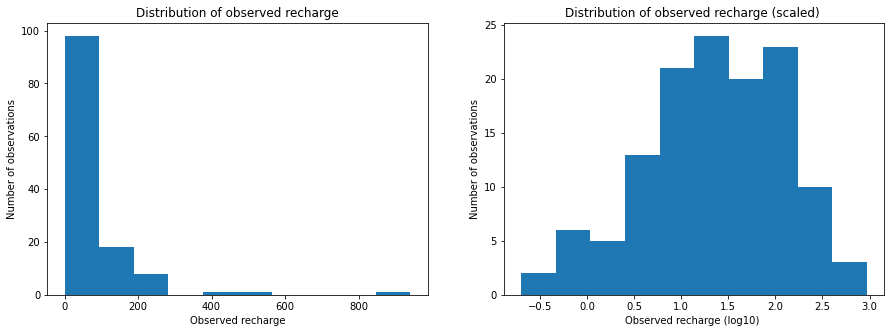

In [3]:
n_bins = 10

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.flatten()
# We can set the number of bins with the `bins` kwarg
axs[0].hist(data['Recharge_mmpa'], bins=n_bins)
axs[0].set_title('Distribution of observed recharge')
axs[0].set_xlabel('Observed recharge')
axs[0].set_ylabel('Number of observations')

axs[1].hist(np.log10(data['Recharge_mmpa']), bins=n_bins)
axs[1].set_title('Distribution of observed recharge (scaled) ')
axs[1].set_xlabel('Observed recharge (log10) ')
axs[1].set_ylabel('Number of observations')

In [4]:
# Labels are the values we want to predict
#labels = data['Recharge_mmpa']
labels = np.log10(data['Recharge_mmpa'])
# Remove the labels from the features
data = data.drop('Recharge_mmpa', axis = 1)
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

 # Experiment 1: 100 runs for reliable importance measure

In [5]:
# collect all importances, R2 and oob values to calculate the average over 100 models
importances = []
train_r2=[]
test_r2=[]
oobs=[]
train_r2_untransf=[]
test_r2_untransf=[]
# find the best model based on the lowest RMSE
best_model = None
best_r2 = 0
best_importances = None
best_train_features, best_test_features, best_train_labels, best_test_labels = None, None, None, None
best_rmse = 300
# find the worst model based on the highest RMSE
worst_model = None
worst_r2 = 100
worst_train_features, worst_test_features, worst_train_labels, worst_test_labels = None, None, None, None
worst_rmse = 0

# run model 100 times
for i in range(0,100):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)    
    # Instantiate models with 2000 decision trees
    rf = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True)
    
    # Train the model on training data
    rf.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    train_predictions = rf.predict(train_features)
    current_r2 = metrics.r2_score(test_labels, predictions)
    current_train_r2 = metrics.r2_score(train_labels, train_predictions)
    
    train_r2.append(current_train_r2)
    test_r2.append(current_r2)
    train_r2_untransf.append(metrics.r2_score(10**train_labels, 10**train_predictions))
    test_r2_untransf.append(metrics.r2_score(10**test_labels, 10**predictions))
    oobs.append(rf.oob_score_)
    print(f'Out-of-bag score estimate: {rf.oob_score_:>5.3}; Train R-2: {current_train_r2:>5.3}, Test R-2: {current_r2:>5.3}')

    current_rmse = metrics.root_mean_squared_error(10**test_labels, 10**predictions)
    print(f"current rmse {current_rmse}")
    if current_r2>best_r2:
        best_rmse = current_rmse
        best_r2 = current_r2
        best_model = rf
        best_importances = rf.feature_importances_
        best_train_features, best_test_features, best_train_labels, best_test_labels = train_features, test_features, train_labels, test_labels
    
    if current_r2<worst_r2:
        worst_r2 = current_r2
        worst_rmse = current_rmse
        worst_model = rf
        worst_train_features, worst_test_features, worst_train_labels, worst_test_labels = train_features, test_features, train_labels, test_labels
    importances.append(rf.feature_importances_)

Out-of-bag score estimate: 0.629; Train R-2: 0.941, Test R-2: 0.672
current rmse 60.676124432842585
Out-of-bag score estimate: 0.642; Train R-2:  0.95, Test R-2: 0.612
current rmse 127.79998224430116
Out-of-bag score estimate: 0.698; Train R-2: 0.955, Test R-2: 0.519
current rmse 132.95368851935748
Out-of-bag score estimate:  0.66; Train R-2: 0.954, Test R-2: 0.596
current rmse 62.427585108966355
Out-of-bag score estimate: 0.673; Train R-2: 0.952, Test R-2: 0.647
current rmse 77.06436434458428
Out-of-bag score estimate: 0.665; Train R-2: 0.952, Test R-2: 0.626
current rmse 143.52618616375676
Out-of-bag score estimate: 0.606; Train R-2: 0.943, Test R-2: 0.757
current rmse 58.272217187406596
Out-of-bag score estimate:  0.72; Train R-2: 0.958, Test R-2: 0.468
current rmse 50.32953841934507
Out-of-bag score estimate: 0.644; Train R-2: 0.944, Test R-2: 0.708
current rmse 80.46933203723577
Out-of-bag score estimate: 0.654; Train R-2: 0.953, Test R-2: 0.599
current rmse 130.55158506897664
Out

Out-of-bag score estimate: 0.644; Train R-2: 0.946, Test R-2: 0.601
current rmse 64.46325220790426
Out-of-bag score estimate: 0.708; Train R-2: 0.953, Test R-2: 0.436
current rmse 127.82105944082971
Out-of-bag score estimate: 0.625; Train R-2: 0.945, Test R-2: 0.687
current rmse 61.282114769959925
Out-of-bag score estimate: 0.644; Train R-2: 0.946, Test R-2: 0.693
current rmse 128.77925030949567
Out-of-bag score estimate: 0.598; Train R-2: 0.941, Test R-2: 0.716
current rmse 79.1313122831712
Out-of-bag score estimate: 0.655; Train R-2: 0.947, Test R-2: 0.617
current rmse 66.89736320468458
Out-of-bag score estimate: 0.671; Train R-2: 0.954, Test R-2: 0.651
current rmse 133.9238817597271
Out-of-bag score estimate: 0.676; Train R-2: 0.955, Test R-2: 0.627
current rmse 85.95779412933751
Out-of-bag score estimate: 0.581; Train R-2: 0.937, Test R-2: 0.704
current rmse 134.0127751823924
Out-of-bag score estimate: 0.555; Train R-2: 0.937, Test R-2: 0.746
current rmse 152.21275257170993
Out-of-

In [6]:
best_predictions = best_model.predict(best_test_features)
# Use the forest's predict method on the training data
best_train_predictions = best_model.predict(best_train_features)

print("+++ METRICS ON LOG-TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2).max()}")
print(f"Min R2 train: {np.array(train_r2).min()}")
print(f"Mean R2 train: {np.array(train_r2).mean()}")
print(f'Best RMSE train: {metrics.root_mean_squared_error(10**best_train_labels, 10**best_train_predictions)}\n')

print(f"Max oob: {np.array(oobs).max()}")
print(f"Min oob: {np.array(oobs).min()}")
print(f"Mean oob: {np.array(oobs).mean()}\n")

print(f"Max R2 test: {np.array(test_r2).max()}")
print(f"Min R2 test: {np.array(test_r2).min()}")
print(f"Mean R2 test: {np.array(test_r2).mean()}")
print(f'Best RMSE test: {metrics.root_mean_squared_error(10**best_test_labels, 10**best_predictions)}\n')

print("+++ METRICS ON BACK TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2_untransf).max()}")
print(f"Min R2 train: {np.array(train_r2_untransf).min()}")
print(f"Mean R2 train: {np.array(train_r2_untransf).mean()}\n")
print(f"Max R2 test: {np.array(test_r2_untransf).max()}")
print(f"Min R2 test: {np.array(test_r2_untransf).min()}")
print(f"Mean R2 test: {np.array(test_r2_untransf).mean()}")

+++ METRICS ON LOG-TRANSFORMED VALUES +++
Max R2 train: 0.9613050013582448
Min R2 train: 0.9295403374867259
Mean R2 train: 0.947989520211878
Best RMSE train: 43.37222745186571

Max oob: 0.7251895045653375
Min oob: 0.5389787216961708
Mean oob: 0.6465200288066277

Max R2 test: 0.7764294945798529
Min R2 test: 0.3255913278892295
Mean R2 test: 0.6239192390915002
Best RMSE test: 128.33247071512056

+++ METRICS ON BACK TRANSFORMED VALUES +++
Max R2 train: 0.8765217561497807
Min R2 train: 0.6511071527950687
Mean R2 train: 0.8009853938464044

Max R2 test: 0.6420583638477669
Min R2 test: -1.2673433351155166
Mean R2 test: 0.27491247870118696


In [7]:
print("+++ Best model metrics +++\n")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {best_model.oob_score_:>5.3}')
print('Best R2 train: ', best_model.score(best_train_features, best_train_labels))
print(f'Best R2 test:  {best_model.score(best_test_features, best_test_labels)}\n')
print("--- back transformed ---")
print(f'Best RMSE train: {metrics.root_mean_squared_error(10**best_train_labels, 10**best_train_predictions)}')
print(f"Best RMSE test: {best_rmse}")
print(f"Best R2 train: {metrics.r2_score(10**best_train_labels, 10**best_train_predictions)}")
print(f"Best R2 test: {metrics.r2_score(10**best_test_labels, 10**best_predictions)}")

+++ Best model metrics +++

--- log transformed ---
Out-of-bag R-2 score estimate: 0.568
Best R2 train:  0.9329817244660756
Best R2 test:  0.7764294945798529

--- back transformed ---
Best RMSE train: 43.37222745186571
Best RMSE test: 128.33247071512056
Best R2 train: 0.7611939691954919
Best R2 test: 0.3190561013987039


In [8]:
worst_predictions = worst_model.predict(worst_test_features)
# Use the forest's predict method on the training data
worst_train_predictions = worst_model.predict(worst_train_features)

print("+++ Worst model metrics +++\n")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {worst_model.oob_score_:>5.3}')
print('worst R2 train: ', worst_model.score(best_train_features, worst_train_labels))
print(f'worst R2 test:  {worst_model.score(best_test_features, worst_test_labels)}\n')
print("--- back transformed ---")
print(f'worst RMSE train: {metrics.root_mean_squared_error(10**worst_train_labels, 10**worst_train_predictions)}')
print(f"worst RMSE test: {worst_rmse}")
print(f"worst R2 train: {metrics.r2_score(10**worst_train_labels, 10**worst_train_predictions)}")
print(f"worst R2 test: {metrics.r2_score(10**worst_test_labels, 10**worst_predictions)}")

+++ Worst model metrics +++

--- log transformed ---
Out-of-bag R-2 score estimate: 0.722
worst R2 train:  -0.532294927369557
worst R2 test:  -1.4489461435666091

--- back transformed ---
worst RMSE train: 54.4345900483489
worst RMSE test: 70.76643665706803
worst R2 train: 0.80090754947241
worst R2 test: 0.39987376191303137


In [9]:
importances = np.array(importances)
mean_importances = np.mean(importances, axis=0)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, mean_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print('Mean feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Mean feature importance
Variable: LTA_P_mmpa           Importance: 0.24
Variable: Aridity              Importance: 0.19
Variable: SM10_m3m3            Importance: 0.19
Variable: LTA_WD_days          Importance: 0.13
Variable: NDVI                 Importance: 0.1
Variable: LTA_PET_mm           Importance: 0.05
Variable: DEM                  Importance: 0.04
Variable: Landcover_NOAA       Importance: 0.02
Variable: Soil_group_cat       Importance: 0.02
Variable: Aquifer_group_cat    Importance: 0.01


In [10]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, best_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
print('Best performing model: feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Best performing model: feature importance
Variable: LTA_P_mmpa           Importance: 0.23
Variable: SM10_m3m3            Importance: 0.19
Variable: Aridity              Importance: 0.17
Variable: LTA_WD_days          Importance: 0.13
Variable: NDVI                 Importance: 0.1
Variable: LTA_PET_mm           Importance: 0.07
Variable: DEM                  Importance: 0.05
Variable: Soil_group_cat       Importance: 0.03
Variable: Landcover_NOAA       Importance: 0.02
Variable: Aquifer_group_cat    Importance: 0.02


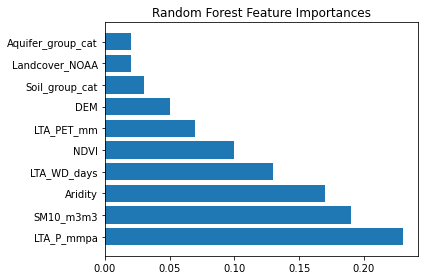

In [11]:
feature_names = [f[0] for f in feature_importances]
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, [f[1] for f in feature_importances])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

## Discourse: MANUAL FEATURE IMPORTANCE ASSESSMENT
code from https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html

#### Permutation importance

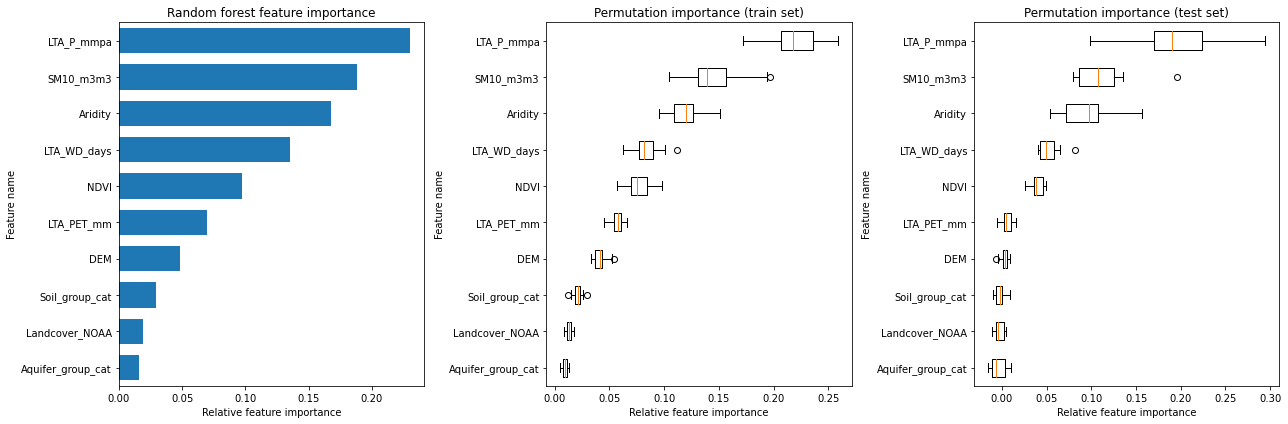

In [12]:
from sklearn.inspection import permutation_importance
feature_names = data.columns

# permutation importance on training set
result_train = permutation_importance(best_model, best_train_features, best_train_labels, n_repeats=30,
                                random_state=42)
perm_sorted_idx = result_train.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(best_model.feature_importances_)
tree_indices = np.arange(0, len(best_model.feature_importances_)) + 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.barh(tree_indices,
         best_model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_title('Random forest feature importance')
ax1.set_ylabel('Feature name')
ax1.set_xlabel('Relative feature importance')
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(best_model.feature_importances_)))
ax2.boxplot(result_train.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[tree_importance_sorted_idx])
ax2.set_title('Permutation importance (train set)')
ax2.set_ylabel('Feature name')
ax2.set_xlabel('Relative feature importance')

# permutation importance on test set
result_test = permutation_importance(best_model, best_test_features, best_test_labels, n_repeats=10,
                                random_state=42)

perm_sorted_idx = result_test.importances_mean.argsort()
ax3.boxplot(result_test.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[tree_importance_sorted_idx])
ax3.set_title('Permutation importance (test set)')
ax3.set_ylabel('Feature name')
ax3.set_xlabel('Relative feature importance')


fig.tight_layout()
plt.show()

#### Spearman rank based hierarchy clustering

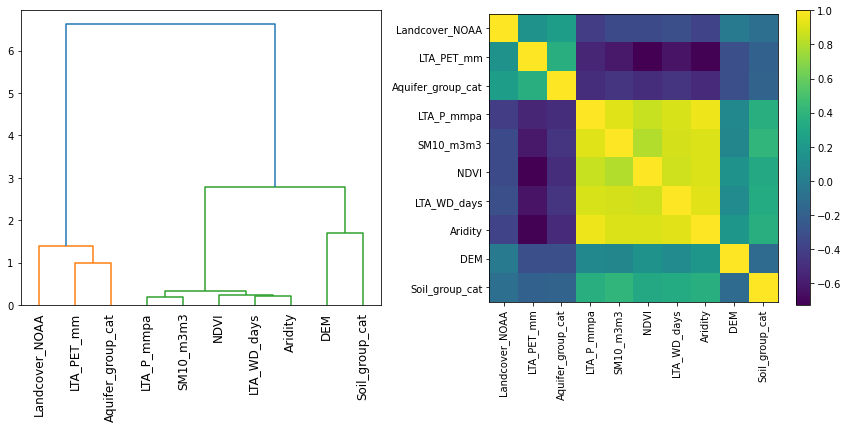

In [13]:
# handle multicollinearity
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
corr = spearmanr(features).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im = ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
fig.colorbar(im)
plt.show()

In [14]:
from collections import defaultdict
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
print(cluster_id_to_feature_ids)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = best_train_features[:, selected_features]
X_test_sel = best_test_features[:, selected_features]

clf_sel = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
clf_sel.fit(X_train_sel, best_train_labels)
print("Accuracy on train data with features removed: {:.2f}".format(
      clf_sel.score(X_train_sel, best_train_labels)))
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, best_test_labels)))

defaultdict(<class 'list'>, {3: [0, 1, 3, 4, 7], 1: [2, 8], 2: [5], 4: [6], 5: [9]})
Accuracy on train data with features removed: 0.93
Accuracy on test data with features removed: 0.65


### add variables
first uncorrelated, then correlated 

under fixed random state

In [15]:
X_train, X_test = best_train_features[:,[0]], best_test_features[:,[0]]
rf_precip = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 1
train_r2 = rf_precip.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[adj R2] Accuracy on train data with precipitation only: {:.2f}".format(train_adj_r2))
print("[adj R2] Accuracy on test data with precipitation only: {:.2f}".format(test_adj_r2))

[adj R2] Accuracy on train data with precipitation only: 0.90
[adj R2] Accuracy on test data with precipitation only: 0.64


In [16]:
X_train, X_test = best_train_features[:,[3]], best_test_features[:,[3]]
rf_arid = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_arid.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 1
train_r2 = rf_arid.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_arid.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[adj R2] Accuracy on train data with aridity only: {:.2f}".format(train_adj_r2))
print("[adj R2] Accuracy on test data with aridity only: {:.2f}".format(test_adj_r2))

[adj R2] Accuracy on train data with aridity only: 0.90
[adj R2] Accuracy on test data with aridity only: 0.61


In [17]:
X_train, X_test = best_train_features[:,[0,2]], best_test_features[:,[0,2]]
rf_precip_pet = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 2
train_r2 = rf_precip_pet.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet only: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet only: {:.2f}".format(test_adj_r2))
print('PET improves!')

[Adj R2] Accuracy on train data with precipitation + pet only: 0.92
[Adj R2] Accuracy on test data with precipitation + pet only: 0.72
PET improves!


In [18]:
X_train, X_test = best_train_features[:,[0,2,8]], best_test_features[:,[0,2,8]]
rf_precip_pet_sm_ai_ndvi_aq = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai_ndvi_aq.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_sm_ai_ndvi_aq.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai_ndvi_aq.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)

print("[Adj R2] Accuracy on train data with precipitation + pet + aq: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aq: {:.2f}".format(test_adj_r2))
print('Aquifer group doesn\'t improve!')

[Adj R2] Accuracy on train data with precipitation + pet + aq: 0.92
[Adj R2] Accuracy on test data with precipitation + pet + aq: 0.69
Aquifer group doesn't improve!


In [19]:
X_train, X_test = best_train_features[:,[0,2,6]], best_test_features[:,[0,2,6]]
rf_precip_pet_dem = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_dem.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_dem.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_dem.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + dem only: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + dem only: {:.2f}".format(test_adj_r2))
print('DEM doesn\'t improve!')

[Adj R2] Accuracy on train data with precipitation + pet + dem only: 0.93
[Adj R2] Accuracy on test data with precipitation + pet + dem only: 0.64
DEM doesn't improve!


In [20]:
X_train, X_test = best_train_features[:,[0,2,9]], best_test_features[:,[0,2,9]]
rf_precip_pet_sg = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sg.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_sg.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sg.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + soil group: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + soil group: {:.2f}".format(test_adj_r2))
print('Soil group doesn\'t improve!')

[Adj R2] Accuracy on train data with precipitation + pet + soil group: 0.92
[Adj R2] Accuracy on test data with precipitation + pet + soil group: 0.67
Soil group doesn't improve!


In [21]:
X_train, X_test = best_train_features[:,[0,2,3]], best_test_features[:,[0,2,3]]
rf_precip_pet_sm_ai = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 3
train_r2 = rf_precip_pet_sm_ai.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity: {:.2f}".format(test_adj_r2))
print('Aridity improves!')

[Adj R2] Accuracy on train data with precipitation + pet + aridity: 0.92
[Adj R2] Accuracy on test data with precipitation + pet + aridity: 0.73
Aridity improves!


In [22]:
X_train, X_test = best_train_features[:,[0,2,3,4]], best_test_features[:,[0,2,3,4]]
rf_precip_pet_sm_ai_ndvi = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai_ndvi.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 4
train_r2 = rf_precip_pet_sm_ai_ndvi.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai_ndvi.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi: {:.2f}".format(test_adj_r2))
print('NDVI improves!')

[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi: 0.93
[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi: 0.75
NDVI improves!


In [23]:
X_train, X_test = best_train_features[:,[0,1,2,3,4]], best_test_features[:,[0,1,2,3,4]]
rf_precip_pet_sm_ai_ndvi_wd = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm_ai_ndvi_wd.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 4
train_r2 = rf_precip_pet_sm_ai_ndvi_wd.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm_ai_ndvi_wd.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + wet days: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi + wet days: {:.2f}".format(test_adj_r2))
print('Number of wet days doesnt improve!')

[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + wet days: 0.93
[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi + wet days: 0.75
Number of wet days doesnt improve!


In [24]:
X_train, X_test = best_train_features[:,[0,2,3,4,7]], best_test_features[:,[0,2,3,4,7]]
rf_precip_pet_lc = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_lc.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 6
train_r2 = rf_precip_pet_lc.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_lc.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + sm: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + + aridity + ndvi + sm: {:.2f}".format(test_adj_r2))
print('Soil moisture improves!')

[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + sm: 0.93
[Adj R2] Accuracy on test data with precipitation + pet + + aridity + ndvi + sm: 0.75
Soil moisture improves!


In [25]:
X_train, X_test = best_train_features[:,[0,2,3,4,5,7]], best_test_features[:,[0,2,3,4,5,7]]
rf_precip_pet_sm = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_precip_pet_sm.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 5
train_r2 = rf_precip_pet_sm.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_precip_pet_sm.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)
print("[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + soil moisture + landcover: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi + soil moisture: + landcover {:.2f}".format(test_adj_r2))
print('Land cover doesn\'t improve!')

[Adj R2] Accuracy on train data with precipitation + pet + aridity + ndvi + soil moisture + landcover: 0.93
[Adj R2] Accuracy on test data with precipitation + pet + aridity + ndvi + soil moisture: + landcover 0.76
Land cover doesn't improve!


In [26]:
X_train, X_test = best_train_features, best_test_features
rf_all = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True, random_state=42)
rf_all.fit(X_train, best_train_labels)

train_n = best_train_features.shape[0]
test_n = best_test_features.shape[0]
p = 9
train_r2 = rf_all.score(X_train, best_train_labels)
train_adj_r2 = 1-(1-train_r2)*(train_n-1)/(train_n-p-1)
test_r2 = rf_all.score(X_test, best_test_labels)
test_adj_r2 = 1-(1-test_r2)*(test_n-1)/(test_n-p-1)

print("[Adj R2] Accuracy on train data with all predictors: {:.2f}".format(train_adj_r2))
print("[Adj R2] Accuracy on test data with all predictors: {:.2f}".format(test_adj_r2))

[Adj R2] Accuracy on train data with all predictors: 0.93
[Adj R2] Accuracy on test data with all predictors: 0.71


### First run: statistics of the best model

In [27]:
print(f'Out-of-bag R-2 score estimate: {best_model.oob_score_:>5.3}')
print('Score: ', best_model.score(best_train_features, best_train_labels))
print('Score: ', best_model.score(best_test_features, best_test_labels))

Out-of-bag R-2 score estimate: 0.568
Score:  0.9329817244660756
Score:  0.7764294945798529


In [28]:
# training set metrics
print('=== Prediction of training set - best performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_train_labels, best_train_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_train_labels, best_train_predictions))
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(best_train_labels, best_train_predictions))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_train_labels, best_train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(best_train_labels, best_train_predictions))
print('Max Error:', metrics.max_error(best_train_labels, best_train_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(best_train_labels, best_train_predictions))
print('R^2:', metrics.r2_score(best_train_labels, best_train_predictions))

=== Prediction of training set - best performing model ===
Mean Absolute Error (MAE): 0.14423241478708831
Mean Squared Error (MSE): 0.03314241162877964
Root Mean Squared Error (RMSE): 0.18205057437091388
Mean Absolute Percentage Error (MAPE): 0.24512936987880843
Explained Variance Score: 0.9330241505215615
Max Error: 0.5129703913161084
Median Absolute Error: 0.11933675630832291
R^2: 0.9329817244660756


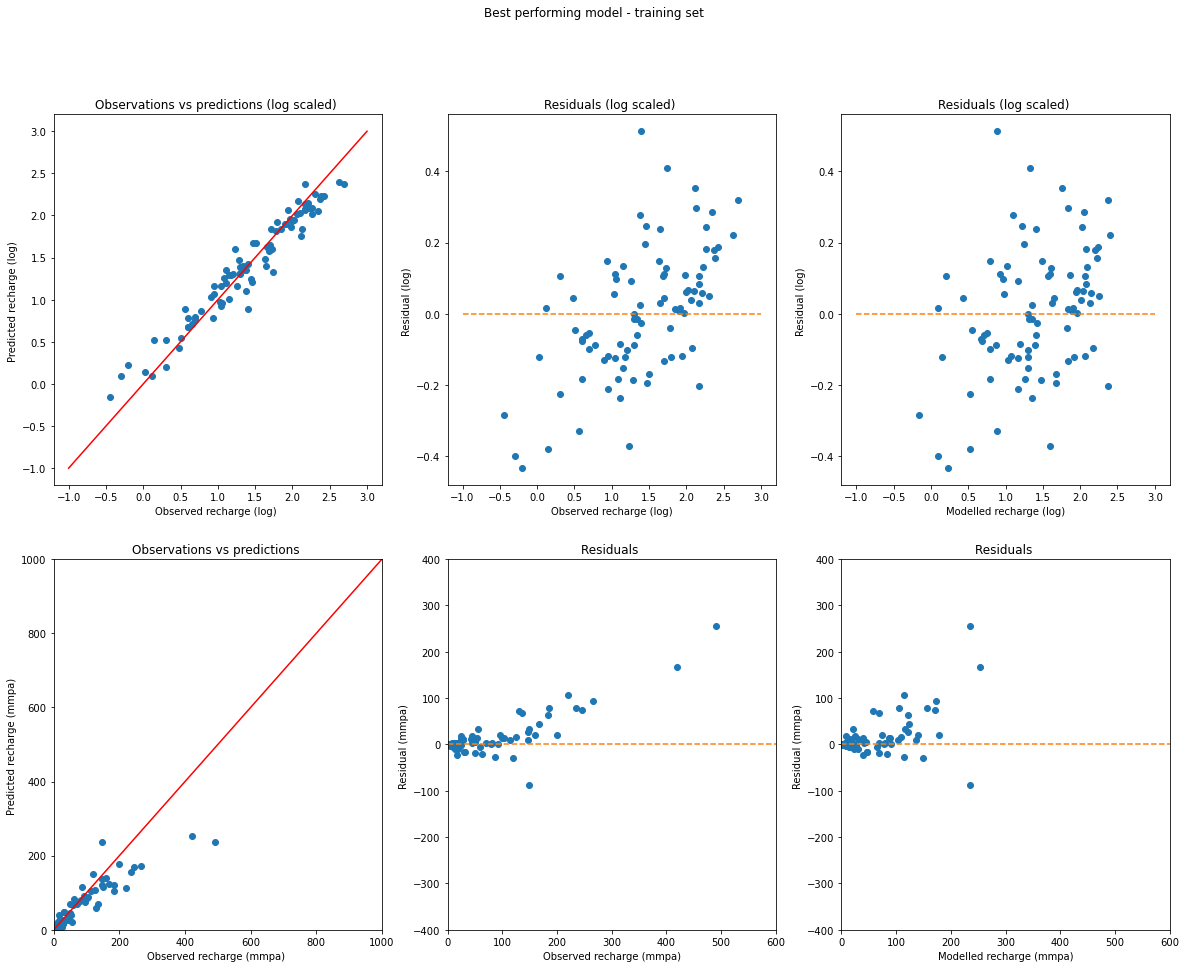

In [29]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Best performing model - training set')
axs = axs.flatten()

axs[0].scatter(best_train_labels, best_train_predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_train_labels, best_train_labels - best_train_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_train_predictions, best_train_labels - best_train_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_train_labels, 10**best_train_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_train_labels, 10**best_train_labels - 10**best_train_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_train_predictions, 10**best_train_labels - 10**best_train_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('Graphics/res_training_best.jpg')

In [30]:
# testing set metrics
print('=== Prediction of testing set - best performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_test_labels, best_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_test_labels, best_predictions))
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(best_test_labels, best_predictions))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_test_labels, best_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(best_test_labels, best_predictions))
print('Max Error:', metrics.max_error(best_test_labels, best_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(best_test_labels, best_predictions))
print('R^2:', metrics.r2_score(best_test_labels, best_predictions))

=== Prediction of testing set - best performing model ===
Mean Absolute Error (MAE): 0.2851198561369084
Mean Squared Error (MSE): 0.13591899250898606
Root Mean Squared Error (RMSE): 0.3686719307310852
Mean Absolute Percentage Error (MAPE): 50733513062337.63
Explained Variance Score: 0.7784820084523139
Max Error: 0.9128333116485701
Median Absolute Error: 0.24231764056889338
R^2: 0.7764294945798529


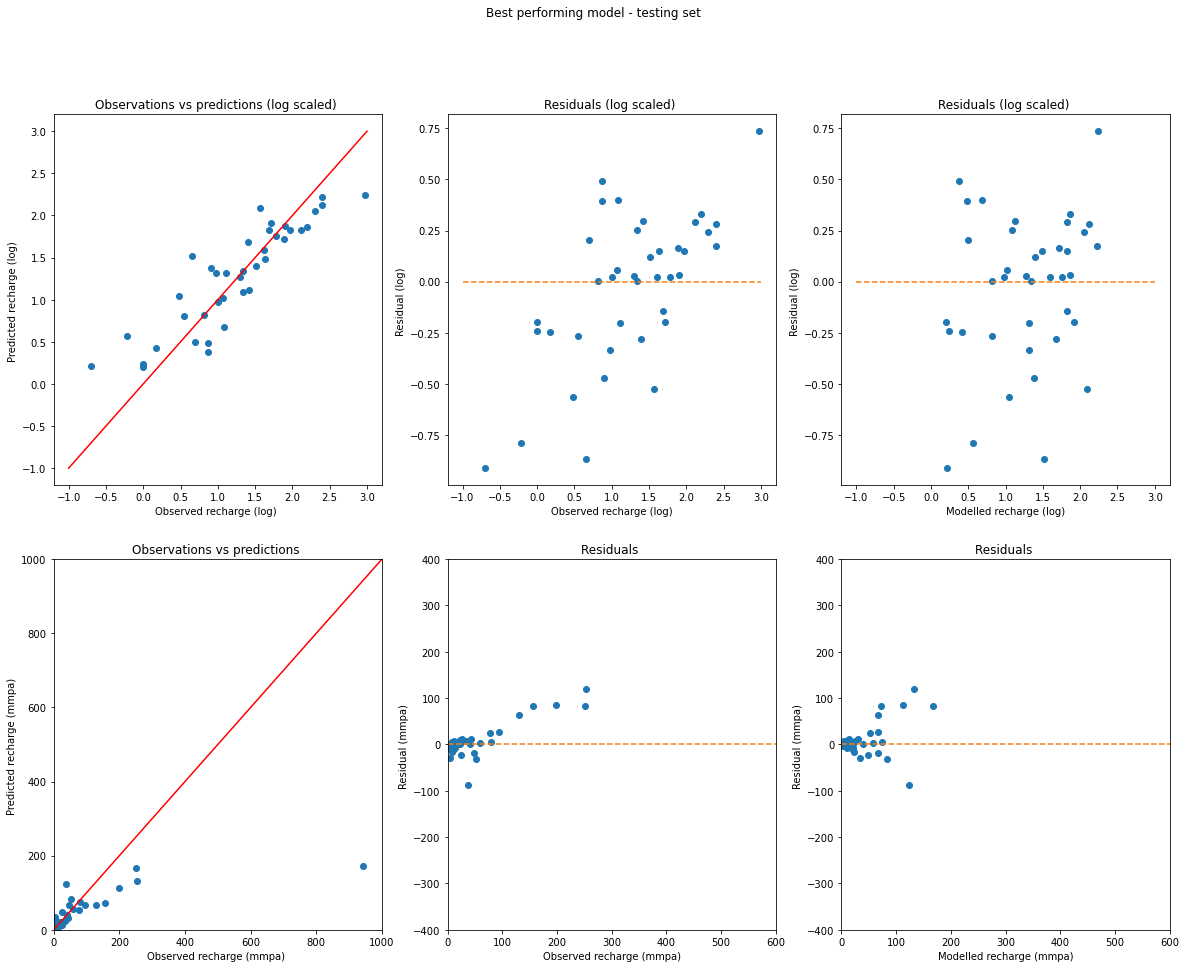

In [31]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Best performing model - testing set')
axs = axs.flatten()

axs[0].scatter(best_test_labels, best_predictions)
axs[
    0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_test_labels, best_test_labels - best_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_predictions, best_test_labels - best_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_test_labels, 10**best_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_test_labels, 10**best_test_labels - 10**best_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_predictions, 10**best_test_labels - 10**best_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('Graphics/res_testing_best.jpg')

### First run: statistics of the worst model

In [32]:
print(f'Out-of-bag R-2 score estimate: {worst_model.oob_score_:>5.3}')
print('Score: ', worst_model.score(worst_train_features, worst_train_labels))
print('Score: ', worst_model.score(worst_test_features, worst_test_labels))

Out-of-bag R-2 score estimate: 0.722
Score:  0.9576952414456833
Score:  0.3255913278892295


In [33]:
# training set metrics
print('=== Prediction of training set - worst performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(worst_train_labels, worst_train_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(worst_train_labels, worst_train_predictions))
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(worst_train_labels, worst_train_predictions))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(worst_train_labels, worst_train_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(worst_train_labels, worst_train_predictions))
print('Max Error:', metrics.max_error(worst_train_labels, worst_train_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(worst_train_labels, worst_train_predictions))
print('R^2:', metrics.r2_score(worst_train_labels, worst_train_predictions))

=== Prediction of training set - worst performing model ===
Mean Absolute Error (MAE): 0.12261263702640318
Mean Squared Error (MSE): 0.02621731532559357
Root Mean Squared Error (RMSE): 0.16191761894739426
Mean Absolute Percentage Error (MAPE): 1204689101445.939
Explained Variance Score: 0.9577072260867396
Max Error: 0.469352248891178
Median Absolute Error: 0.09237390852970015
R^2: 0.9576952414456833


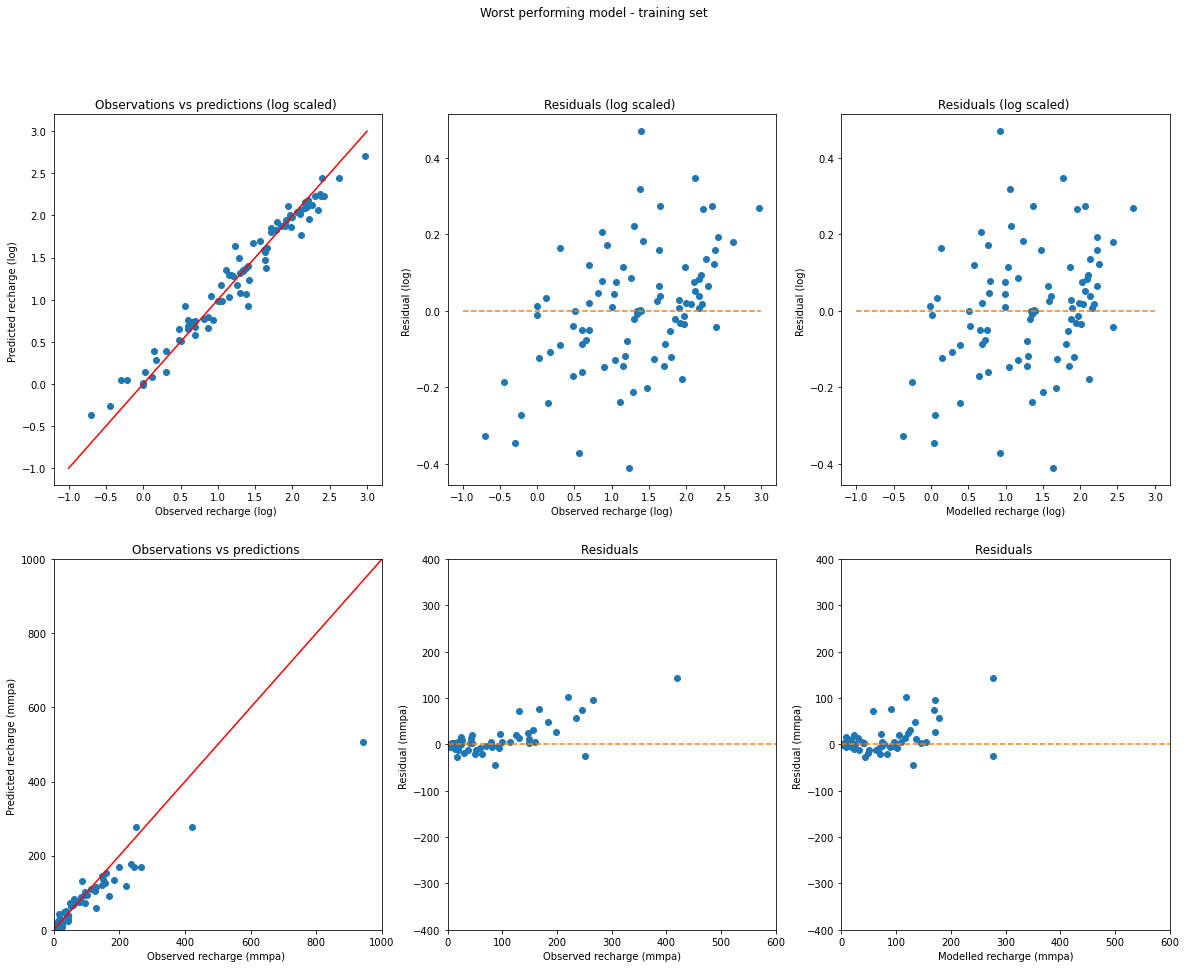

In [34]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Worst performing model - training set')
axs = axs.flatten()

axs[0].scatter(worst_train_labels, worst_train_predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(worst_train_labels, worst_train_labels - worst_train_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(worst_train_predictions, worst_train_labels - worst_train_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**worst_train_labels, 10**worst_train_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**worst_train_labels, 10**worst_train_labels - 10**worst_train_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**worst_train_predictions, 10**worst_train_labels - 10**worst_train_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('Graphics/res_training_worst.jpg')

In [35]:
# testing set metrics
print('=== Prediction of testing set - worst performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(worst_test_labels, worst_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(worst_test_labels, worst_predictions))
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(worst_test_labels, worst_predictions))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(worst_test_labels, worst_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(worst_test_labels, worst_predictions))
print('Max Error:', metrics.max_error(worst_test_labels, worst_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(worst_test_labels, worst_predictions))
print('R^2:', metrics.r2_score(worst_test_labels, worst_predictions))

=== Prediction of testing set - worst performing model ===
Mean Absolute Error (MAE): 0.3689630624402244
Mean Squared Error (MSE): 0.221145413929847
Root Mean Squared Error (RMSE): 0.47026100617619465
Mean Absolute Percentage Error (MAPE): 0.37072676756071804
Explained Variance Score: 0.34666393248943983
Max Error: 1.1836831081256367
Median Absolute Error: 0.27414122359802917
R^2: 0.3255913278892295


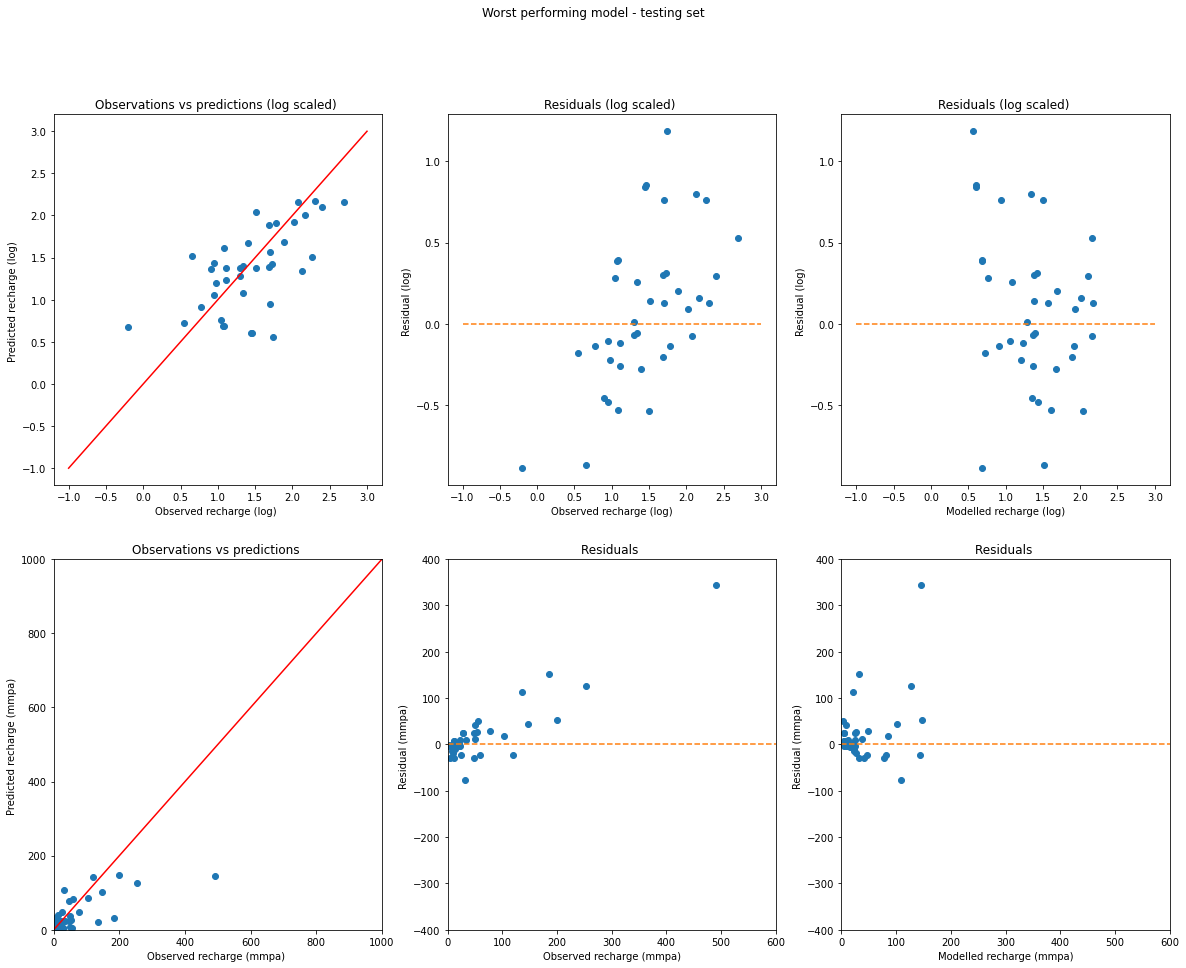

In [36]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Worst performing model - testing set')
axs = axs.flatten()

axs[0].scatter(worst_test_labels, worst_predictions)
axs[
    0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(worst_test_labels, worst_test_labels - worst_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(worst_predictions, worst_test_labels - worst_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**worst_test_labels, 10**worst_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**worst_test_labels, 10**worst_test_labels - 10**worst_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**worst_predictions, 10**worst_test_labels - 10**worst_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('Graphics/res_testing_worst.jpg')

# Experiment 2: use important predictors only 

In [37]:
important_indices = [feature_list.index('LTA_P_mmpa'),
                     feature_list.index('LTA_PET_mm'),
                     feature_list.index('Aridity'), 
                     feature_list.index('NDVI'),
                     feature_list.index('SM10_m3m3')]

In [38]:
from sklearn.model_selection import RandomizedSearchCV

estimator = RandomForestRegressor()
# Number of trees in random forest
n_estimators = [2000] * 10
# Number of features to consider at every split
max_features = ['log2', 'sqrt', 0.33]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
              }

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=estimator, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(features[:, important_indices], labels)

rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_features': 0.33,
 'max_depth': 90}

In [39]:
# collect all importances, R2 and oob values to calculate the average over 100 models
importances = []
train_r2=[]
train_r2_untransf = []
test_r2_untransf = []
test_r2=[]
oobs=[]

# find the best model based on the lowest RMSE
best_model2 = None
best_r2 = 0
best_importances = None
best_train_features2, best_test_features2, best_train_labels2, best_test_labels2 = None, None, None, None
best_rmse = 300

# find the worst model based on the highest RMSE
worst_r2 = 100
worst_model2 = None
worst_train_features2, worst_test_features2, worst_train_labels2, worst_test_labels2 = None, None, None, None
worst_rmse = 0

#params = {'n_estimators': 2000}
params = {'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 0.33,
 'max_depth': 80,
 'bootstrap': True}

for i in range(0,100):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.3)    
    # Instantiate models with tunned hyperparameters
    rf = RandomForestRegressor(**params, oob_score=True)
      
    # Train the model on training data
    rf.fit(train_features[:,important_indices], train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features[:,important_indices])
    train_predictions = rf.predict(train_features[:, important_indices])
    current_r2 = metrics.r2_score(test_labels, predictions)
    current_train_r2 = metrics.r2_score(train_labels, train_predictions)
    
    train_r2.append(current_train_r2)
    test_r2.append(current_r2)
    train_r2_untransf.append(metrics.r2_score(10**train_labels, 10**train_predictions))
    test_r2_untransf.append(metrics.r2_score(10**test_labels, 10**predictions))
    oobs.append(rf.oob_score_)
    
    print(f'[{i}] Out-of-bag score estimate: {rf.oob_score_:>5.3}; Train R-2: {current_train_r2:>5.3}, Test R-2: {current_r2:>5.3}')

    current_rmse = metrics.root_mean_squared_error(10**test_labels, 10**predictions)
    print(f"current rmse {current_rmse}")
    if current_r2>best_r2:
        best_r2 = current_r2
        best_rmse = current_rmse
        best_model2 = rf
        best_importances = rf.feature_importances_
        best_train_features2, best_test_features2, best_train_labels2, best_test_labels2 = train_features, test_features, train_labels, test_labels
    if current_r2<worst_r2:
        worst_r2 = current_r2
        worst_rmse = current_rmse
        worst_model2 = rf
        worst_train_features2, worst_test_features2, worst_train_labels2, worst_test_labels2 = train_features, test_features, train_labels, test_labels
    importances.append(rf.feature_importances_)

[0] Out-of-bag score estimate:  0.63; Train R-2: 0.818, Test R-2: 0.702
current rmse 71.88602383971073
[1] Out-of-bag score estimate: 0.688; Train R-2: 0.851, Test R-2: 0.637
current rmse 131.88932035840617
[2] Out-of-bag score estimate:  0.67; Train R-2: 0.837, Test R-2: 0.647
current rmse 48.736313775037004
[3] Out-of-bag score estimate: 0.643; Train R-2: 0.826, Test R-2:  0.71
current rmse 62.172952493921706
[4] Out-of-bag score estimate:  0.66; Train R-2:  0.84, Test R-2: 0.678
current rmse 125.05185153868533
[5] Out-of-bag score estimate: 0.689; Train R-2: 0.845, Test R-2: 0.625
current rmse 68.75674814130572
[6] Out-of-bag score estimate: 0.682; Train R-2: 0.843, Test R-2: 0.617
current rmse 128.7307687096873
[7] Out-of-bag score estimate: 0.632; Train R-2: 0.824, Test R-2: 0.733
current rmse 57.89006745619958
[8] Out-of-bag score estimate: 0.653; Train R-2: 0.829, Test R-2: 0.675
current rmse 130.90401700945216
[9] Out-of-bag score estimate: 0.668; Train R-2: 0.835, Test R-2: 0.

[79] Out-of-bag score estimate: 0.656; Train R-2:  0.83, Test R-2: 0.691
current rmse 49.33188058045492
[80] Out-of-bag score estimate: 0.609; Train R-2: 0.811, Test R-2: 0.757
current rmse 146.40089076923985
[81] Out-of-bag score estimate: 0.723; Train R-2: 0.862, Test R-2: 0.486
current rmse 40.97780143244006
[82] Out-of-bag score estimate: 0.681; Train R-2: 0.843, Test R-2: 0.611
current rmse 80.81019523212935
[83] Out-of-bag score estimate: 0.674; Train R-2: 0.843, Test R-2: 0.654
current rmse 44.21171101661375
[84] Out-of-bag score estimate: 0.607; Train R-2: 0.822, Test R-2: 0.663
current rmse 93.65681296040748
[85] Out-of-bag score estimate: 0.639; Train R-2: 0.824, Test R-2: 0.657
current rmse 51.46631263731188
[86] Out-of-bag score estimate: 0.628; Train R-2: 0.819, Test R-2:  0.69
current rmse 52.38850632898896
[87] Out-of-bag score estimate: 0.635; Train R-2:  0.82, Test R-2: 0.697
current rmse 53.57452346515731
[88] Out-of-bag score estimate: 0.614; Train R-2: 0.806, Test R

In [40]:
best_predictions2 = best_model2.predict(best_test_features2[:,important_indices])
# Use the forest's predict method on the training data
best_train_predictions2 = best_model2.predict(best_train_features2[:,important_indices])

print("+++ METRICS ON LOG-TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2).max()}")
print(f"Min R2 train: {np.array(train_r2).min()}")
print(f"Mean R2 train: {np.array(train_r2).mean()}")
print(f'Best RMSE train: {metrics.root_mean_squared_error(10**best_train_labels2, 10**best_train_predictions2)}\n')

print(f"Max oob: {np.array(oobs).max()}")
print(f"Min oob: {np.array(oobs).min()}")
print(f"Mean oob: {np.array(oobs).mean()}\n")

print(f"Max R2 test: {np.array(test_r2).max()}")
print(f"Min R2 test: {np.array(test_r2).min()}")
print(f"Mean R2 test: {np.array(test_r2).mean()}")
print(f'Best RMSE test: {metrics.root_mean_squared_error(10**best_test_labels2, 10**best_predictions2)}\n')

print("+++ METRICS ON BACK TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2_untransf).max()}")
print(f"Min R2 train: {np.array(train_r2_untransf).min()}")
print(f"Mean R2 train: {np.array(train_r2_untransf).mean()}\n")
print(f"Max R2 test: {np.array(test_r2_untransf).max()}")
print(f"Min R2 test: {np.array(test_r2_untransf).min()}")
print(f"Mean R2 test: {np.array(test_r2_untransf).mean()}")

+++ METRICS ON LOG-TRANSFORMED VALUES +++
Max R2 train: 0.8671098915835349
Min R2 train: 0.7980260433001001
Mean R2 train: 0.8346971727021674
Best RMSE train: 87.28908579796614

Max oob: 0.736482014687948
Min oob: 0.5879505266720721
Mean oob: 0.6621701663669568

Max R2 test: 0.7833511574956367
Min R2 test: 0.4841752958380885
Mean R2 test: 0.6631368587102172
Best RMSE test: 56.23558792098808

+++ METRICS ON BACK TRANSFORMED VALUES +++
Max R2 train: 0.6814550017904488
Min R2 train: 0.4121510422760756
Mean R2 train: 0.5279840996966695

Max R2 test: 0.7409301222167384
Min R2 test: -1.0565710459792736
Mean R2 test: 0.35014370727155664


In [41]:
print("+++ Best model metrics +++")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {best_model2.oob_score_:>5.3}')
print('Best R2 train: ', best_model2.score(best_train_features2[:, important_indices], best_train_labels2))
print(f'Best R2 test:  {best_model2.score(best_test_features2[:, important_indices], best_test_labels2)}\n')
print("--- back transformed ---")
print(f'Best RMSE train: {metrics.root_mean_squared_error(10**best_train_labels2, 10**best_train_predictions2)}')
print(f"Best RMSE test: {best_rmse}")
print(f"Best R2 train: {metrics.r2_score(10**best_train_labels2, 10**best_train_predictions2)}")
print(f"Best R2 test: {metrics.r2_score(10**best_test_labels2, 10**best_predictions2)}")

+++ Best model metrics +++
--- log transformed ---
Out-of-bag R-2 score estimate: 0.638
Best R2 train:  0.8268739937067625
Best R2 test:  0.7833511574956367

--- back transformed ---
Best RMSE train: 87.28908579796614
Best RMSE test: 56.23558792098808
Best R2 train: 0.529746442153466
Best R2 test: 0.41304500308686287


In [42]:
worst_predictions2 = worst_model2.predict(worst_test_features2[:,important_indices])
# Use the forest's predict method on the training data
worst_train_predictions2 = worst_model2.predict(worst_train_features2[:,important_indices])
print("+++ Worst model metrics +++")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {worst_model2.oob_score_:>5.3}')
print('Worst R2 train: ', worst_model2.score(worst_train_features2[:, important_indices], worst_train_labels2))
print(f'Worst R2 test:  {worst_model2.score(worst_test_features2[:, important_indices], worst_test_labels2)}\n')
print("--- back transformed ---")
print(f'Worst RMSE train: {metrics.root_mean_squared_error(10**worst_train_labels2, 10**worst_train_predictions2)}')
print(f"Worst RMSE test: {worst_rmse}")
print(f"Worst R2 train: {metrics.r2_score(10**worst_train_labels2, 10**worst_train_predictions2)}")
print(f"Worst R2 test: {metrics.r2_score(10**worst_test_labels2, 10**worst_predictions2)}")

+++ Worst model metrics +++
--- log transformed ---
Out-of-bag R-2 score estimate: 0.685
Worst R2 train:  0.8491441635225028
Worst R2 test:  0.4841752958380885

--- back transformed ---
Worst RMSE train: 87.30198387580211
Worst RMSE test: 70.07153789942338
Worst R2 train: 0.4973009141628292
Worst R2 test: 0.3492619850777082


In [43]:
importances = np.array(importances)
mean_importances = np.mean(importances, axis=0)
feature_list = ['LTA_P_mmpa', 'LTA_PET_mm', 'Aridity', 'NDVI', 'SM10_m3m3']
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, mean_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print('Mean feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Mean feature importance
Variable: LTA_P_mmpa           Importance: 0.24
Variable: Aridity              Importance: 0.23
Variable: SM10_m3m3            Importance: 0.22
Variable: NDVI                 Importance: 0.19
Variable: LTA_PET_mm           Importance: 0.12


In [44]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, best_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
print('Best performing model: feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Best performing model: feature importance
Variable: LTA_P_mmpa           Importance: 0.25
Variable: Aridity              Importance: 0.24
Variable: SM10_m3m3            Importance: 0.21
Variable: NDVI                 Importance: 0.19
Variable: LTA_PET_mm           Importance: 0.12


### Second run: statistics of the best model
Total dataset size: 134 samples <br>
Training set: 100 samples <br>
Testing set: 34 samples

Features used (after importance analysis):
- LTA precipitation (mmpa)
- LTA wet days
- LTA_PET_mm
- Aridity idx
- LTA NDVI
- DEM
- LTA soil moisture - 10cm (kgm-2)

In [45]:
print(f'Out-of-bag R-2 score estimate: {best_model2.oob_score_:>5.3}')
print('Score: ', best_model2.score(best_train_features2[:,important_indices], best_train_labels2))
print('Score: ', best_model2.score(best_test_features2[:,important_indices], best_test_labels2))

Out-of-bag R-2 score estimate: 0.638
Score:  0.8268739937067625
Score:  0.7833511574956367


In [46]:
print('=== Training set metrics - best performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_train_labels2, best_train_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_train_labels2, best_train_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(best_train_labels2, best_train_predictions2))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_train_labels2, best_train_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(best_train_labels2, best_train_predictions2))
print('R^2:', metrics.r2_score(best_train_labels2, best_train_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**best_train_labels2, 10**best_train_predictions2))

=== Training set metrics - best performing model ===
Mean Absolute Error (MAE): 0.24043522222462224
Mean Squared Error (MSE): 0.09729503560423586
Root Mean Squared Error (RMSE): 0.31192152154706454
Mean Absolute Percentage Error (MAPE): 5931665983627.634
Explained Variance Score: 0.8268749517095051
R^2: 0.8268739937067625
=== after back transformation ===
R^2: 0.529746442153466


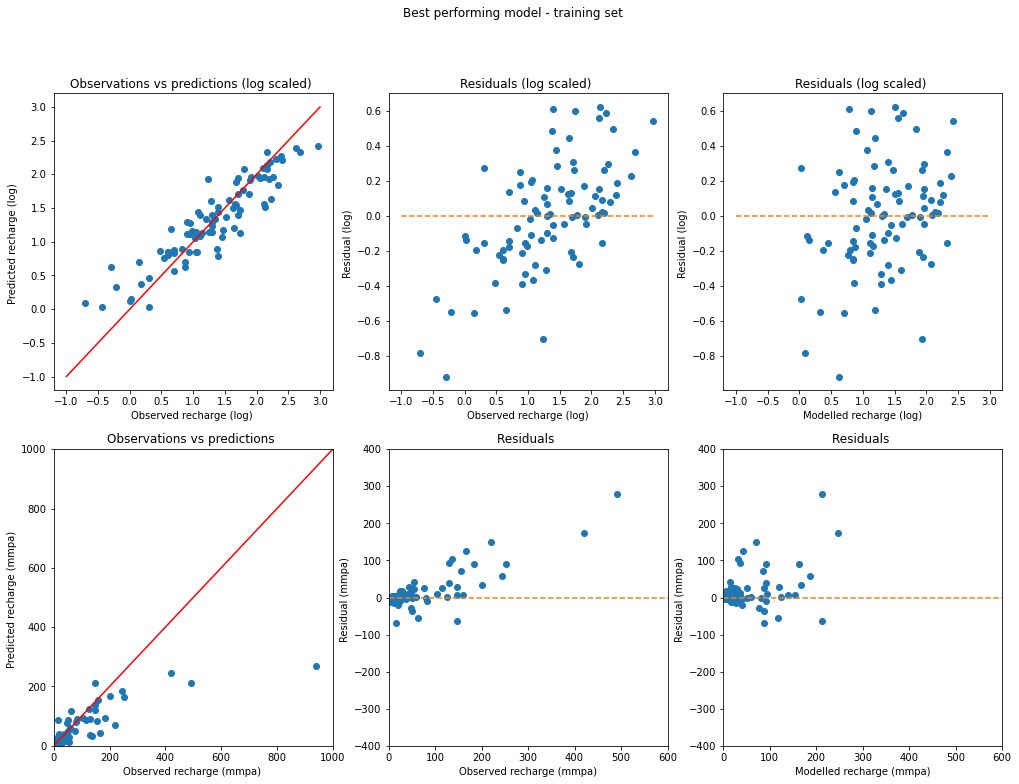

In [47]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Best performing model - training set')
axs = axs.flatten()

axs[0].scatter(best_train_labels2, best_train_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_train_labels2, best_train_labels2 - best_train_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_train_predictions2, best_train_labels2 - best_train_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_train_labels2, 10**best_train_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_train_labels2, 10**best_train_labels2 - 10**best_train_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_train_predictions2, 10**best_train_labels2 - 10**best_train_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('Graphics/res_training_2_best.jpg')

In [48]:
print('=== Testing set metrics - best performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_test_labels2, best_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_test_labels2, best_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(best_test_labels2, best_predictions2))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_test_labels2, best_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(best_test_labels2, best_predictions2))
print('Max Error:', metrics.max_error(best_test_labels2, best_predictions2))
print('R^2:', metrics.r2_score(best_test_labels2, best_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**best_test_labels2, 10**best_predictions2))

=== Testing set metrics - best performing model ===
Mean Absolute Error (MAE): 0.23789411975478067
Mean Squared Error (MSE): 0.10061835294538303
Root Mean Squared Error (RMSE): 0.31720396111237803
Mean Absolute Percentage Error (MAPE): 9455677599199.96
Explained Variance Score: 0.7852414542178707
Max Error: 0.9626126459282252
R^2: 0.7833511574956367
=== after back transformation ===
R^2: 0.41304500308686287


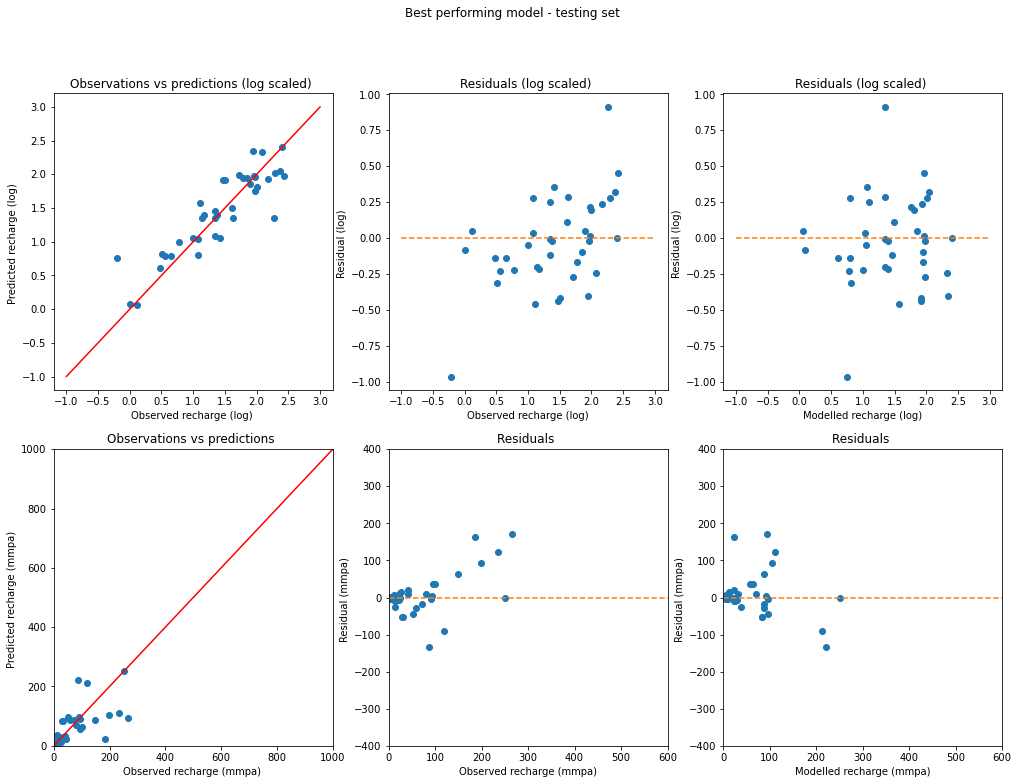

In [49]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Best performing model - testing set')
axs = axs.flatten()

axs[0].scatter(best_test_labels2, best_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_test_labels2, best_test_labels2 - best_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_predictions2, best_test_labels2 - best_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_test_labels2, 10**best_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_test_labels2, 10**best_test_labels2 - 10**best_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_predictions2, 10**best_test_labels2 - 10**best_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('Graphics/res_testing_2_best.jpg')

### Second run: statistics of the worst model


In [50]:
print(f'Out-of-bag R-2 score estimate: {worst_model2.oob_score_:>5.3}')
print('Score: ', worst_model2.score(worst_train_features2[:,important_indices], worst_train_labels2))
print('Score: ', worst_model2.score(worst_test_features2[:,important_indices], worst_test_labels2))

Out-of-bag R-2 score estimate: 0.685
Score:  0.8491441635225028
Score:  0.4841752958380885


In [51]:
print('=== Training set metrics - worst performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(worst_train_labels2, worst_train_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(worst_train_labels2, worst_train_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(worst_train_labels2, worst_train_predictions2))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(worst_train_labels2, worst_train_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(worst_train_labels2, worst_train_predictions2))
print('R^2:', metrics.r2_score(worst_train_labels2, worst_train_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**worst_train_labels2, 10**worst_train_predictions2))

=== Training set metrics - worst performing model ===
Mean Absolute Error (MAE): 0.2198705191288666
Mean Squared Error (MSE): 0.08887422946390856
Root Mean Squared Error (RMSE): 0.2981178113831989
Mean Absolute Percentage Error (MAPE): 5962719860110.504
Explained Variance Score: 0.8491649267627924
R^2: 0.8491441635225028
=== after back transformation ===
R^2: 0.4973009141628292


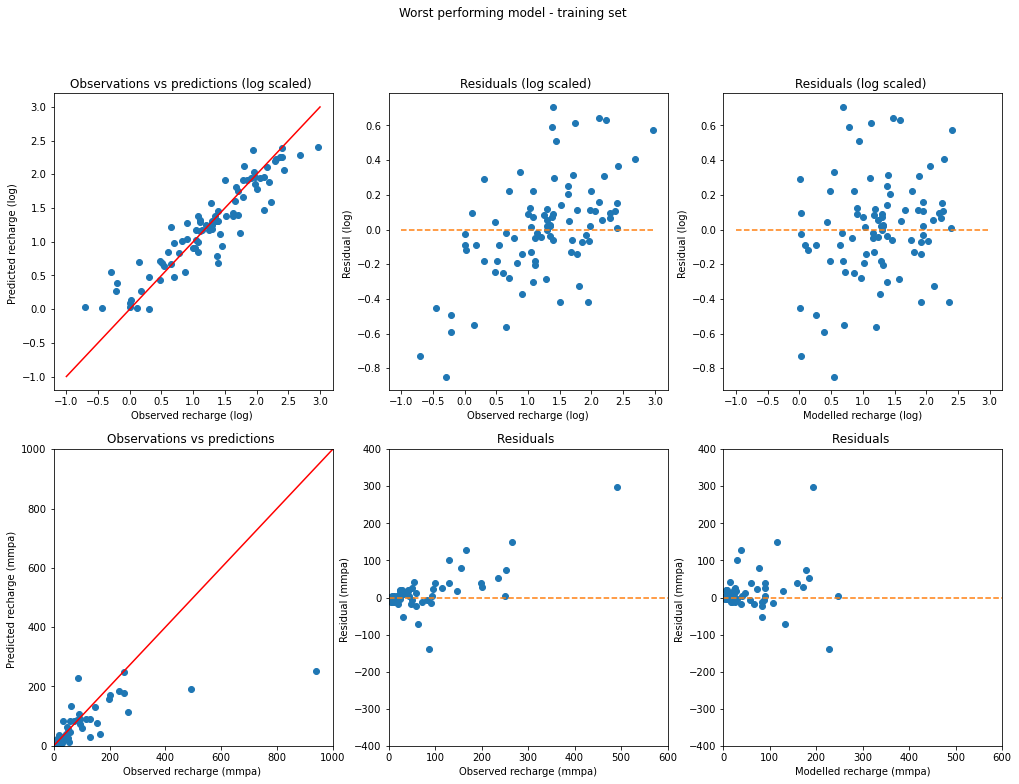

In [52]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Worst performing model - training set')
axs = axs.flatten()

axs[0].scatter(worst_train_labels2, worst_train_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(worst_train_labels2, worst_train_labels2 - worst_train_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(worst_train_predictions2, worst_train_labels2 - worst_train_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**worst_train_labels2, 10**worst_train_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**worst_train_labels2, 10**worst_train_labels2 - 10**worst_train_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**worst_train_predictions2, 10**worst_train_labels2 - 10**worst_train_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

fig.savefig('Graphics/res_training_2_worst.jpg')

In [53]:
print('=== Testing set metrics - worst performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(worst_test_labels2, worst_predictions2))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(worst_test_labels2, worst_predictions2))
print('Root Mean Squared Error (RMSE):', metrics.root_mean_squared_error(worst_test_labels2, worst_predictions2))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(worst_test_labels2, worst_predictions2))
print('Explained Variance Score:', metrics.explained_variance_score(worst_test_labels2, worst_predictions2))
print('Max Error:', metrics.max_error(worst_test_labels2, worst_predictions2))
print('R^2:', metrics.r2_score(worst_test_labels2, worst_predictions2))

print('=== after back transformation ===')
print('R^2:', metrics.r2_score(10**worst_test_labels2, 10**worst_predictions2))

=== Testing set metrics - worst performing model ===
Mean Absolute Error (MAE): 0.3258755757200881
Mean Squared Error (MSE): 0.16790863816475435
Root Mean Squared Error (RMSE): 0.40976656545496043
Mean Absolute Percentage Error (MAPE): 0.24630249997668857
Explained Variance Score: 0.49109676578849015
Max Error: 1.0693885293042793
R^2: 0.4841752958380885
=== after back transformation ===
R^2: 0.3492619850777082


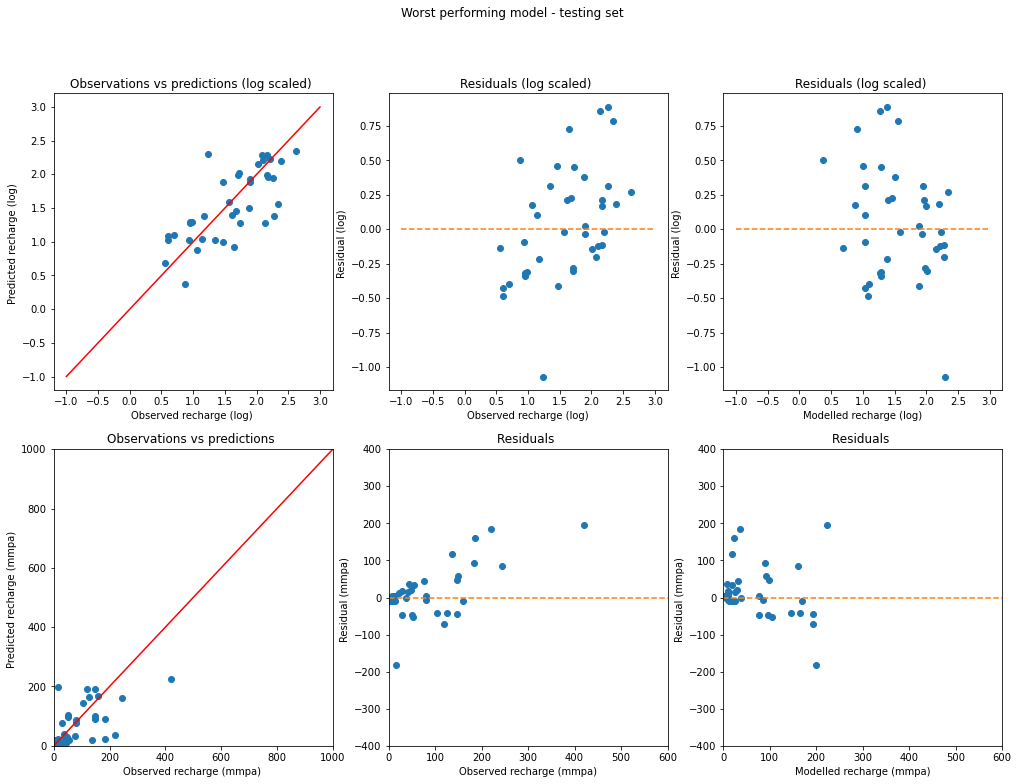

In [54]:
fig, axs = plt.subplots(2,3,figsize=(17,12))
fig.suptitle('Worst performing model - testing set')
axs = axs.flatten()

axs[0].scatter(worst_test_labels2, worst_predictions2)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(worst_test_labels2, worst_test_labels2 - worst_predictions2,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(worst_predictions2, worst_test_labels2 - worst_predictions2,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**worst_test_labels2, 10**worst_predictions2)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**worst_test_labels2, 10**worst_test_labels2 - 10**worst_predictions2,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**worst_predictions2, 10**worst_test_labels2 - 10**worst_predictions2,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

fig.savefig('Graphics/res_testing_2_worst.jpg')